# **Классификация автомобилей.**

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats as sts
from scipy.stats import shapiro
from sklearn.preprocessing import RobustScaler, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import joblib
import warnings
warnings.filterwarnings("ignore")

# Визуализация.

In [115]:
def visualize_missing_values(dataframe):
    """
    Визуализация матрицы пропусков
    :param dataframe: датафрейм
    :return: матрица пропусков
    """
    msno.matrix(dataframe)
    plt.show()


In [116]:
def plot_boxplot(df, column_name):
    """
    Визуализация ящика с усами
    :param df: датафрейм
    :param column_name: название столбца
    :return: ящик с усами
    """
    plt.figure(figsize=(5, 3))
    sns.boxplot(df[column_name])
    plt.title(f'{column_name}')
    plt.show()


In [117]:
def plot_confusion_matrix(y_test, y_pred, class_names, normalize=False, cmap=plt.cm.Blues):
    """
    Визуализация матрицы ошибок
    :param y_test: значения y на тесте
    :param y_pred: предсказанные y
    :param class_names: список классов
    :return: матрица ошибок
    """
    cm = confusion_matrix(y_test, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title="Confusion Matrix",
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(),
             rotation=45,
             ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.show()


# Очистка данных.

In [118]:
def remove_column(df, column_name):
    """
    Удаление столбца из датафрейма
    :param df: датафрейм
    :param column_name: название столбца
    :return: датафрейм
    """
    df = df.drop(columns=[column_name])

    return df


In [119]:
def drop_rows_with_many_nans(df, miss):
    """
    Удаление строк, в которых отсутствуют более miss значений
    :param df: датафрейм
    :param miss: число пропусков
    :return: датафрейм
    """
    df_cleaned = df[df.isnull().sum(axis=1) <= miss]

    return df_cleaned


In [120]:
def fill_missing_values_with_median(df):
    """
    Заполнение пропусков медианой
    :param df: датафрейм
    :return: датафрейм
    """
    df_filled = df.copy()

    for column in df_filled.columns:
        if df_filled[column].dtype in ['float64', 'int64']:
            median_value = df_filled[column].median()
            df_filled[column].fillna(median_value, inplace=True)

    return df_filled


In [121]:
def replace_outliers_with_median(df, column_name):
    """
    Замена выбросов медианой с помощью IQR
    :param df: датафрейм
    :param column_name: название столбца
    :return: датафрейм
    """
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median = df[column_name].median()

    df[column_name] = df[column_name].apply(lambda x: median if x < lower_bound or x > upper_bound else x)

    return df


In [122]:
def remove_duplicates(df):
    """
    Удаление дубликатов
    :param df: датафрейм
    :return: датафрейм
    """
    return df.drop_duplicates()


# Разведочный анализ данных.

In [123]:
def plot_pie_chart(df, column_name):
    """
    Визуализация круговой диаграммы
    :param df: датафрейм
    :param column_name: название столбца
    :return: круговая диаграмма
    """
    value_counts = df[column_name].value_counts()
    plt.figure(figsize=(8, 8))
    value_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis', legend=True)
    plt.title('Распределение классов')
    plt.show()


In [124]:
def plot_distribution_and_check_normality(df, column_name):
    """
    Визуализация распределения для конкретного столбца
    :param df: датафрейм
    :param column_name: название столбца
    :return: Распределение для столбца
    """
    data = df[column_name].dropna()

    plt.figure(figsize=(5, 3))
    sns.histplot(data, kde=True, bins=20)
    plt.title(f'{column_name}')
    plt.xlabel(column_name)

    stat, p_value = shapiro(data)

    alpha = 0.05
    if p_value > alpha:
        print("Распределение данных похоже на нормальное (не удалось отвергнуть нулевую гипотезу).")
    else:
        print("Распределение данных не является нормальным (отвергаем нулевую гипотезу).")

    plt.show()


In [125]:
def analyze_correlations(df, exclude_column='Тип кузова'):
    """
    Визуализация корреляционной матрицы
    :param df: датафрейм
    :return: корреляционная матрица
    """
    df = df.drop(columns=[exclude_column])

    correlation_matrix = df.corr()

    plt.figure(figsize=(7, 5))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
    plt.title('Корреляционная матрица')
    plt.show()


In [126]:
def cramers_v(confusion_matrix):
    """
    Вычисление значения cramer_v
    :param confusion_matrix: матрица для расчёта статистики
    :return: значение cramer_v
    """
    chi2 = sts.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1) / (n - 1)))
    rcorr = r - ((r - 1) ** 2 / (n - 1))
    kcorr = k - ((k - 1) ** 2 / (n - 1))
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


def categorical_correlations(df, cat_column):
    """
    Отображение таблицы со значениями коэффициентов корреляции
    :param df: датафрейм
    :param cat_column: категориальный столбец
    :return: датафрейм
    """
    results = []
    for col in df.columns:
        if col != cat_column:
            if pd.api.types.is_numeric_dtype(df[col]):
                confusion_matrix = pd.crosstab(df[cat_column], pd.cut(df[col], bins=5))
                cramers_v_value = cramers_v(confusion_matrix)
                results.append((col, cramers_v_value))

    return pd.DataFrame(results, columns=['Column', 'CramerV'])


# Подготовка к обучению модели.

In [127]:
def calculate_variances(df, exclude_column='Тип кузова'):
    """
    Отображение таблицы с расчитанными дисперсиями каждого столбца
    :param df: датафрейм
    :return: таблица со значениями дисперсиями
    """
    df = df.drop(columns=[exclude_column])
    variances = df.var()

    return variances


In [128]:
def scale_feature_with_robust_scaler(df, column_name):
    """
    Масштабирование столбца
    :param df: датафрейм
    :param column_name: название столбца
    :return: датафрейм
    """
    scaler = RobustScaler()
    df[column_name] = scaler.fit_transform(df[[column_name]])

    return df


In [129]:
def split_train_test(df, test_size, random_state):
    """
    Разделение выборки на train и test
    :param df: датафрейм
    :param test_size: размер выборки для test
    :param random_state: значение состояния (зерно генерации)
    :return: датафреймы для train и test
    """
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)

    return train_df, test_df


# Обработка данных.

## Загрузка данных.

In [130]:
df = pd.read_excel('Automobiles.xlsx')

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1019 entries, 0 to 1018
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id_modification                        1019 non-null   int64  
 1   Марка                                  1019 non-null   object 
 2   Серия                                  1019 non-null   object 
 3   Тип кузова                             1019 non-null   object 
 4   Полная масса [кг]                      925 non-null    float64
 5   Максимальный крутящий момент [Н*м]     1018 non-null   float64
 6   Мощность двигателя [л.с.]              1018 non-null   float64
 7   Объём топливного бака [л]              1012 non-null   float64
 8   Разгон до 100 км/ч [сек]               770 non-null    float64
 9   Максимальная скорость [км/ч]           872 non-null    float64
 10  Расход топлива в городе на 100 км [л]  817 non-null    float64
 11  Расх

In [132]:
df.head()

,id_modification,Марка,Серия,Тип кузова,Полная масса [кг],Максимальный крутящий момент [Н*м],Мощность двигателя [л.с.],Объём топливного бака [л],Разгон до 100 км/ч [сек],Максимальная скорость [км/ч],Расход топлива в городе на 100 км [л],Расход топлива на шоссе на 100 км [л]
0,208720,BMW,Кабриолет,Кабриолет,1940.0,300.0,143.0,51.0,9.6,208.0,7.3,4.9
1,208729,BMW,Кабриолет,Кабриолет,1915.0,300.0,143.0,51.0,9.5,208.0,5.8,4.4
2,208715,BMW,Кабриолет,Кабриолет,1885.0,190.0,143.0,53.0,10.1,208.0,8.7,5.4
3,208722,BMW,Кабриолет,Кабриолет,1885.0,190.0,143.0,53.0,10.1,208.0,9.2,5.7
4,208723,BMW,Кабриолет,Кабриолет,1860.0,190.0,143.0,53.0,9.3,210.0,8.5,5.5


## Удаление ненужных столбцов.

In [133]:
df = remove_column(df, 'id_modification')
df = remove_column(df, 'Марка')
df = remove_column(df, 'Серия')

## Поиск и обработка пропусков.

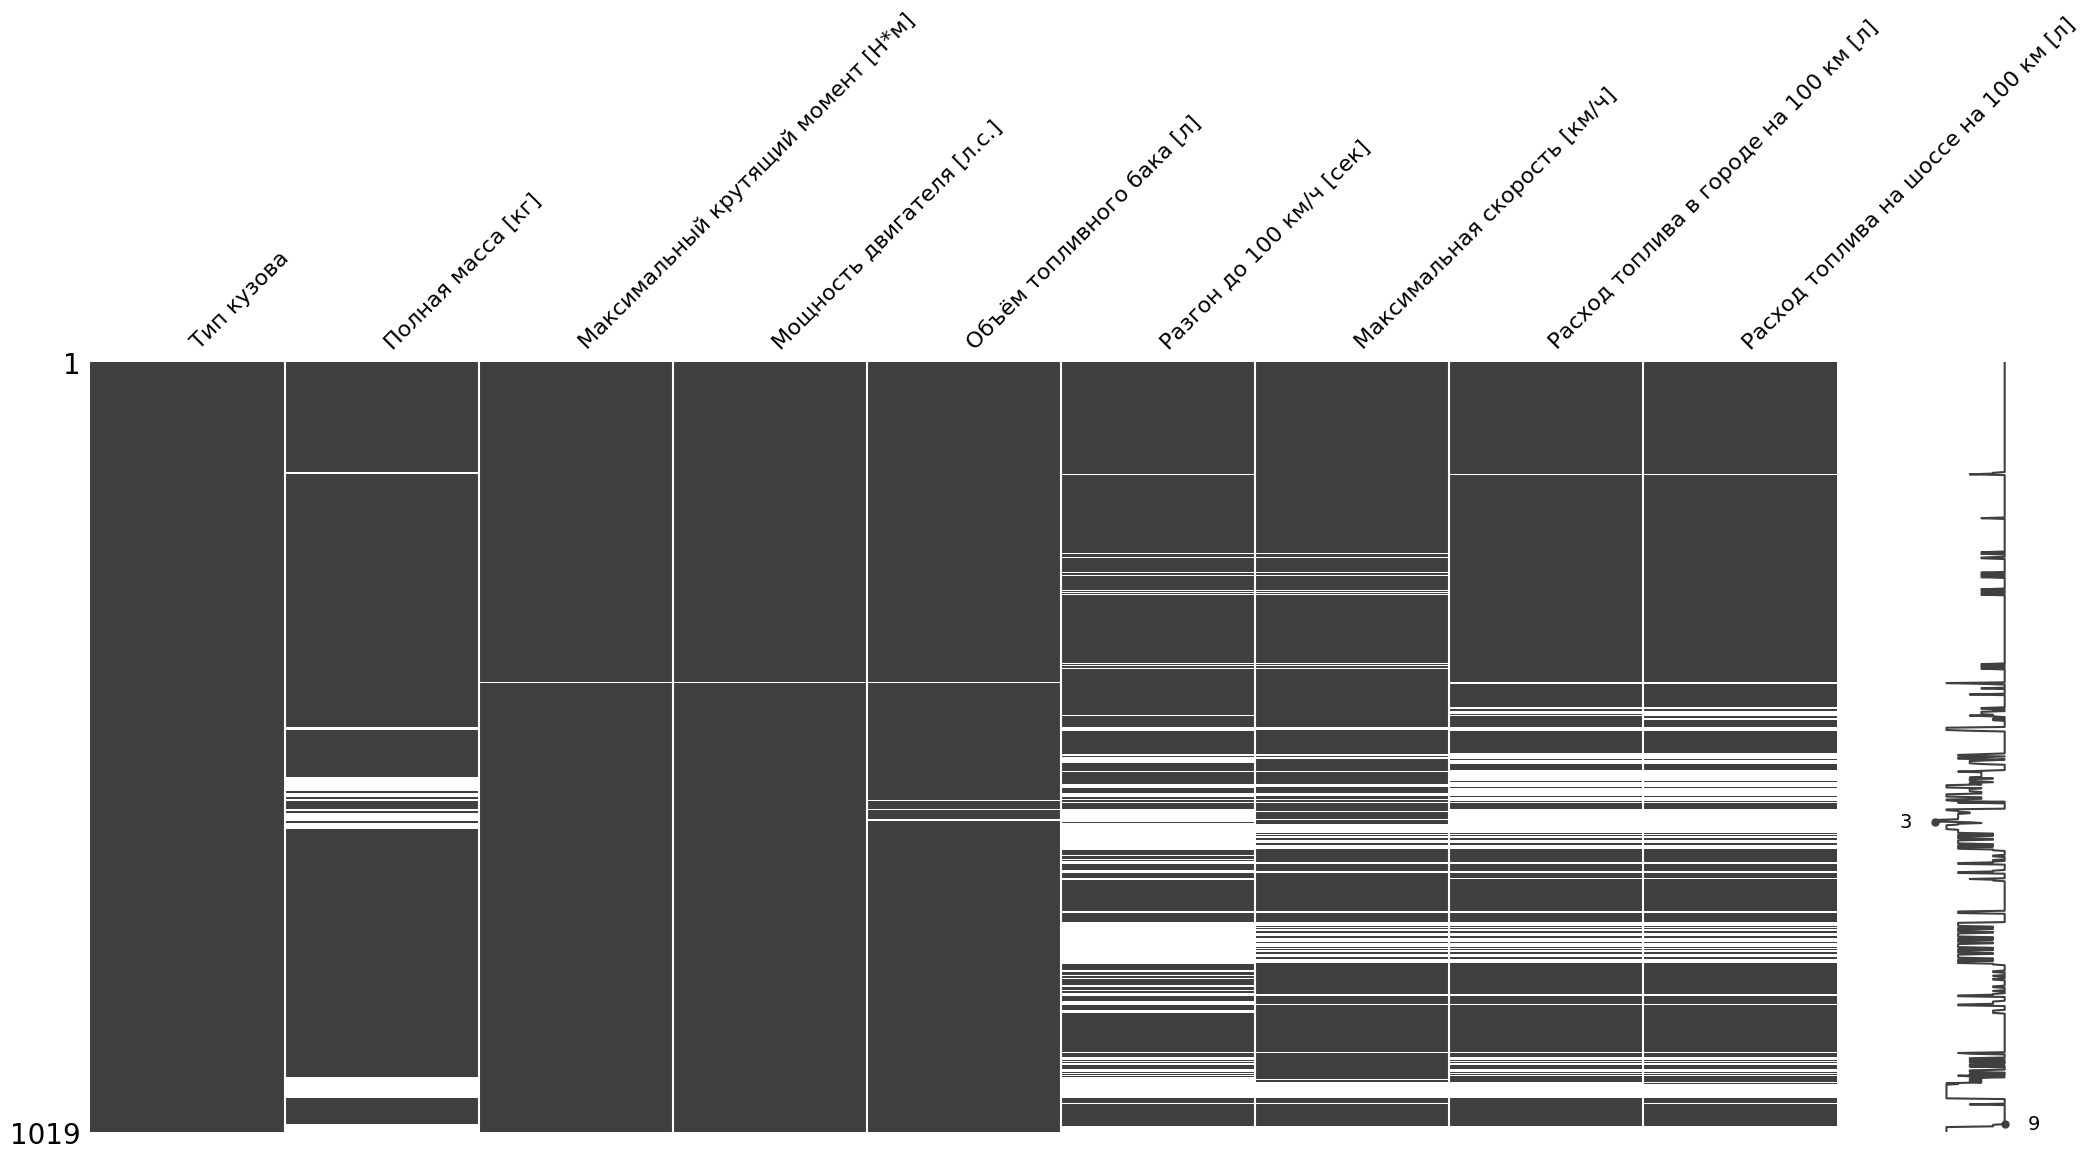

In [134]:
visualize_missing_values(df)

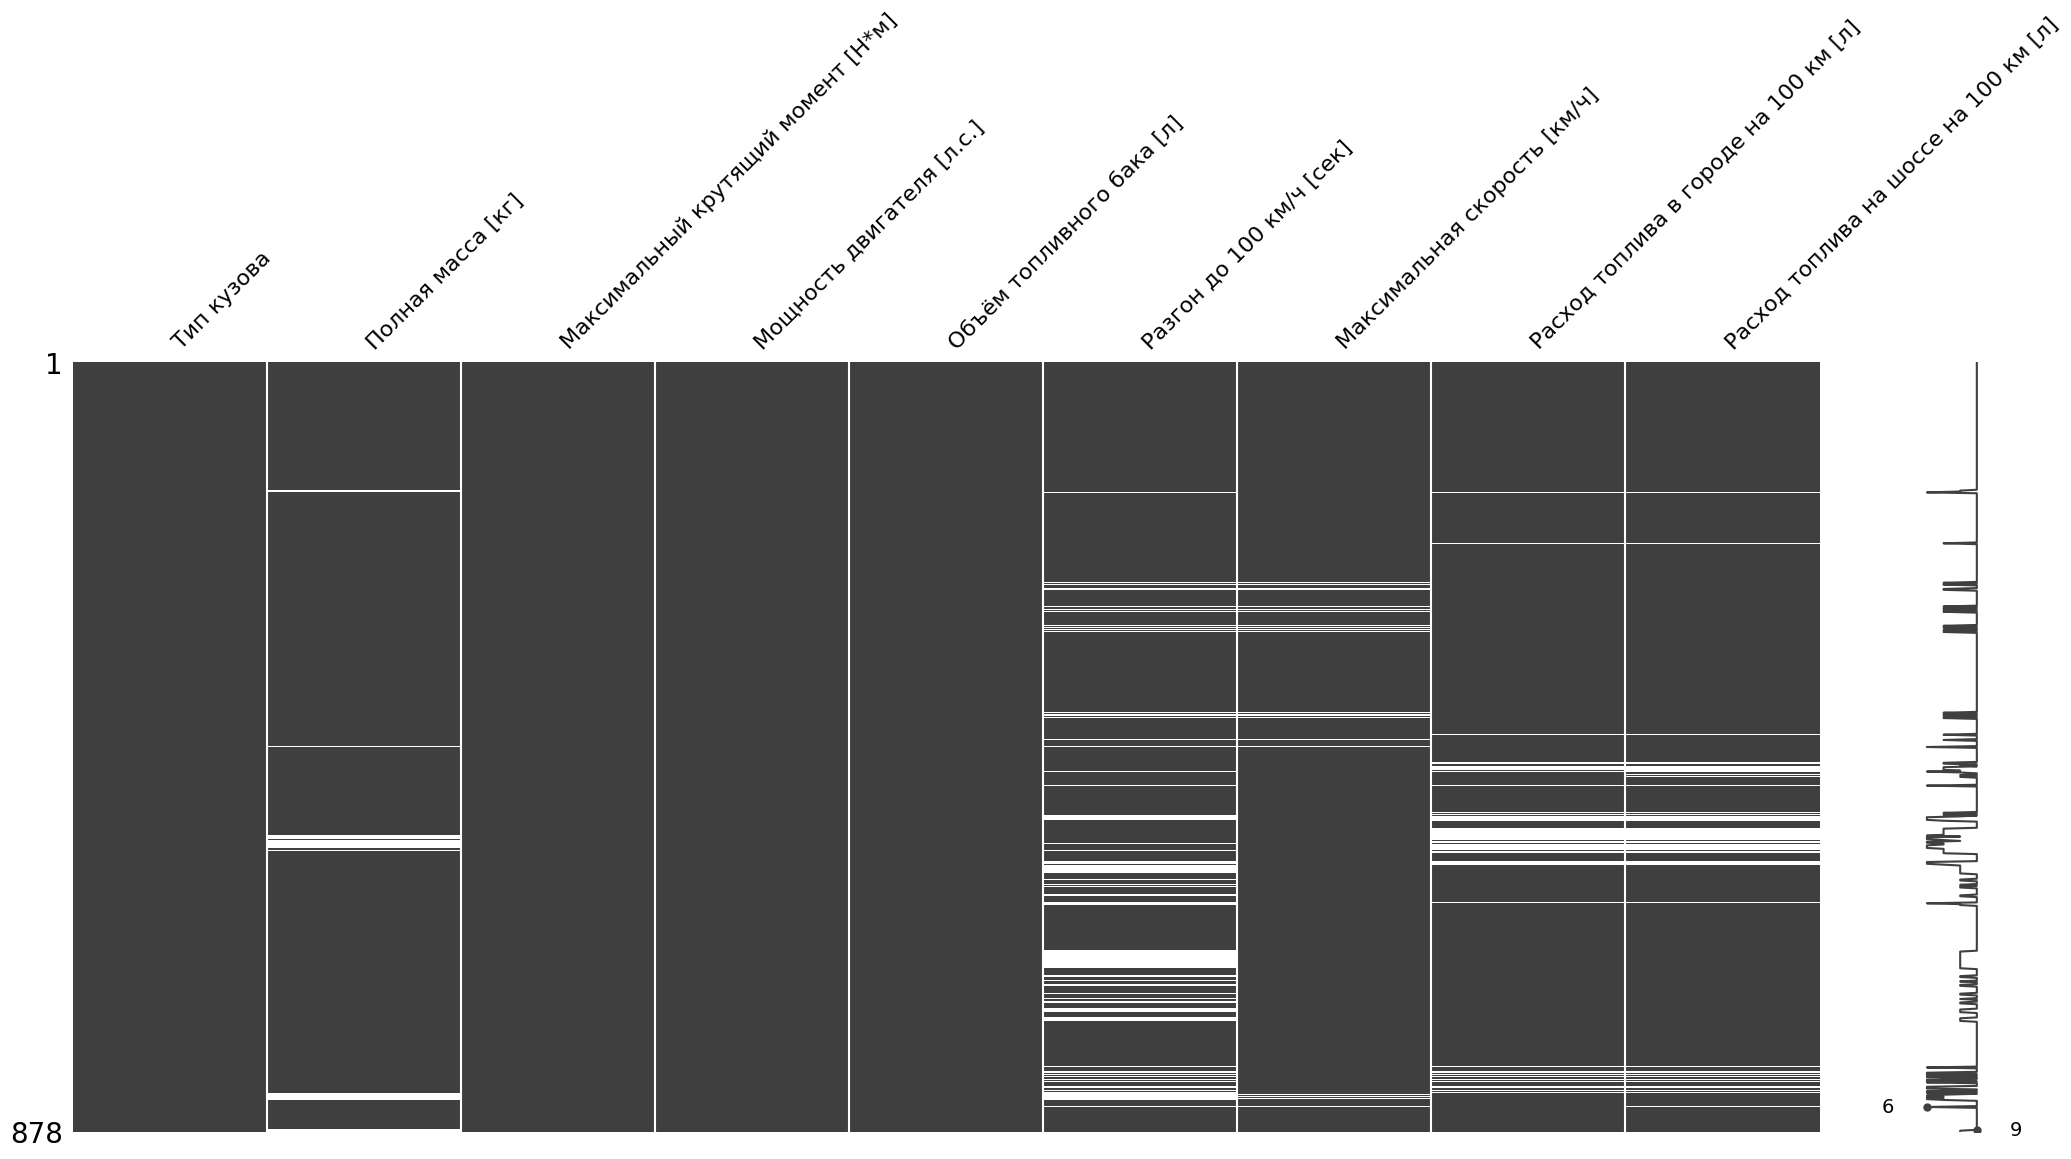

In [135]:
df = drop_rows_with_many_nans(df, 3)
visualize_missing_values(df)

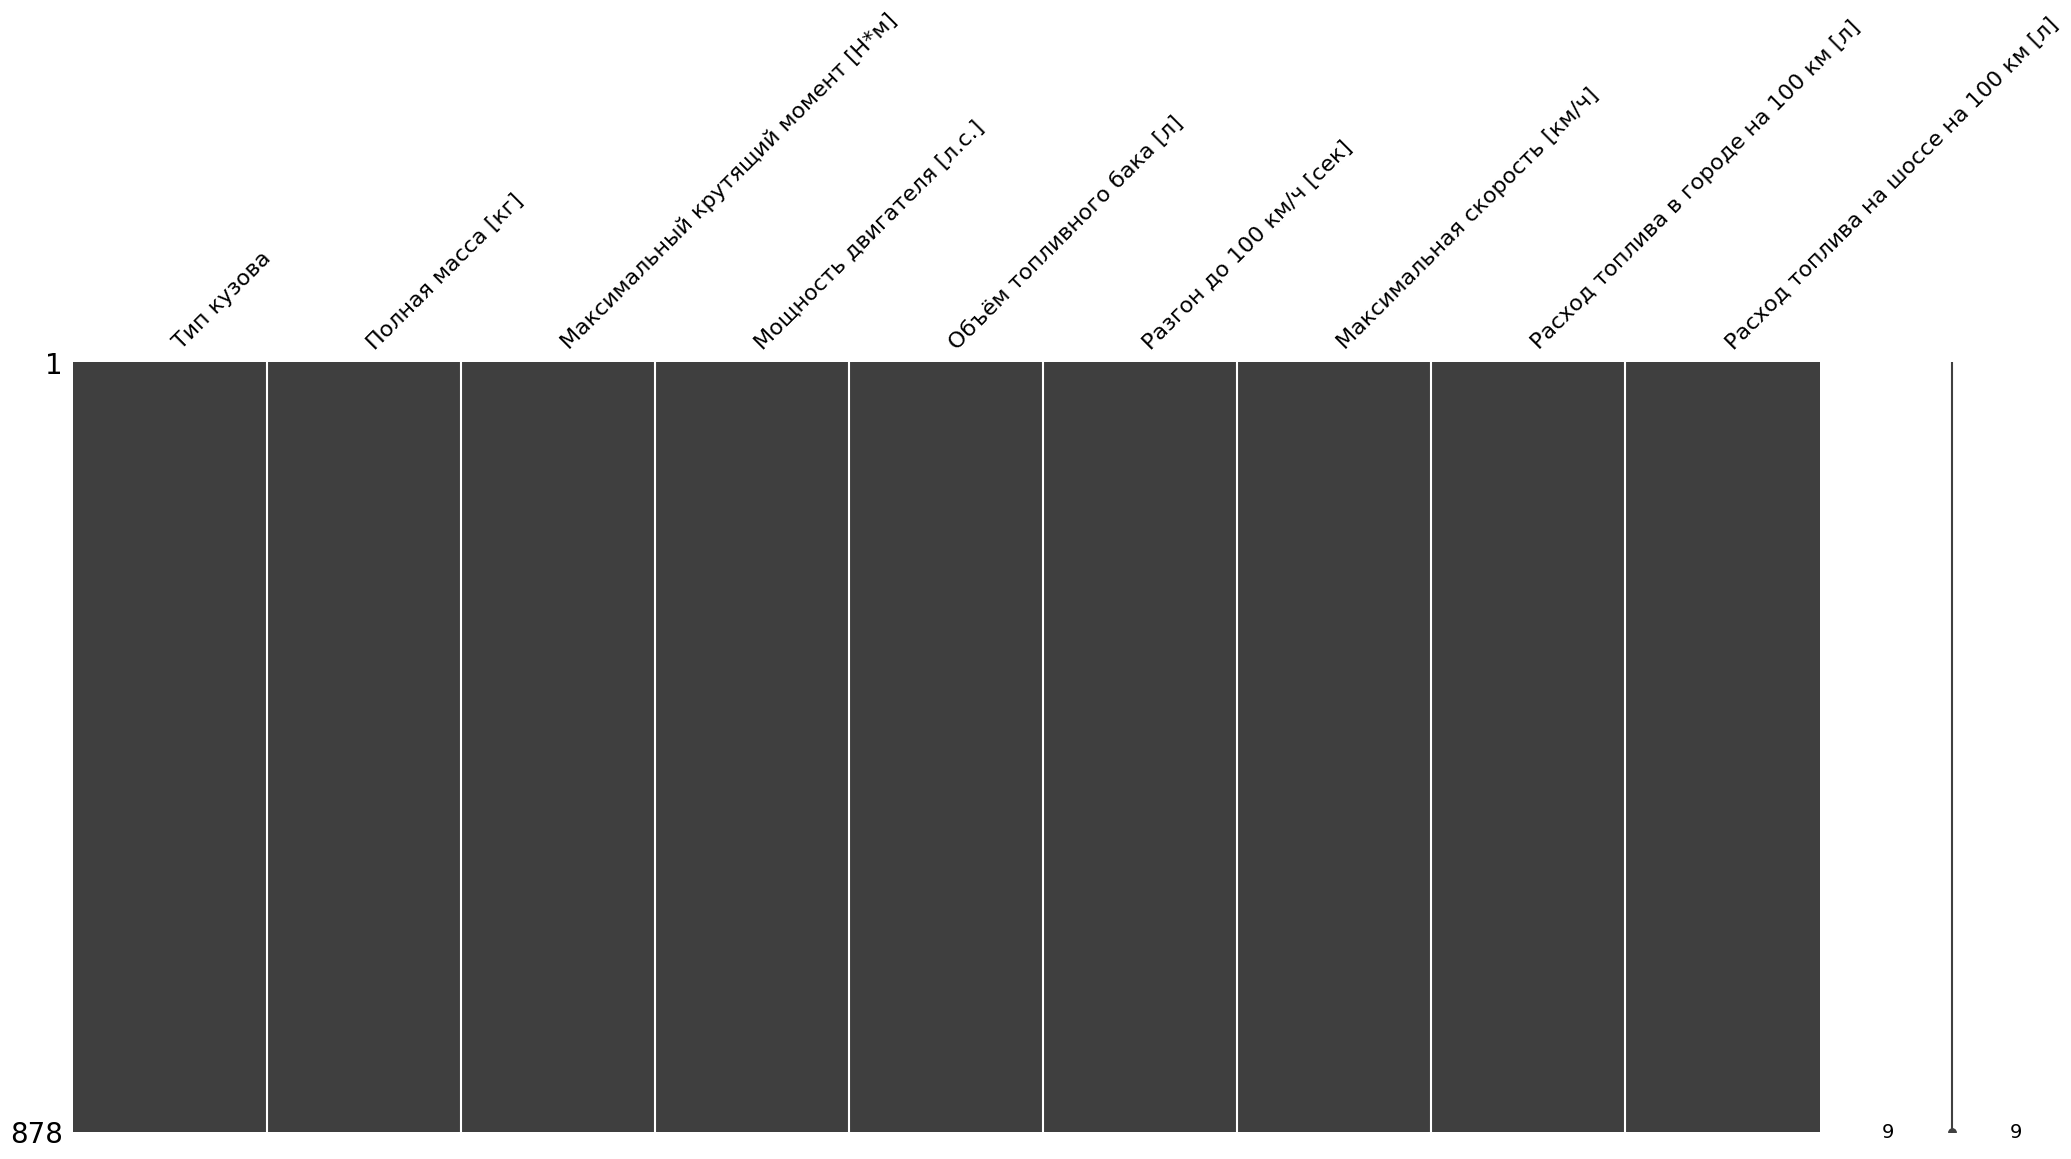

In [136]:
df = fill_missing_values_with_median(df)
visualize_missing_values(df)

## Поиск и обработка выбросов.

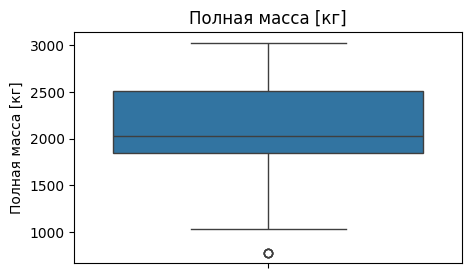

In [137]:
plot_boxplot(df, 'Полная масса [кг]')

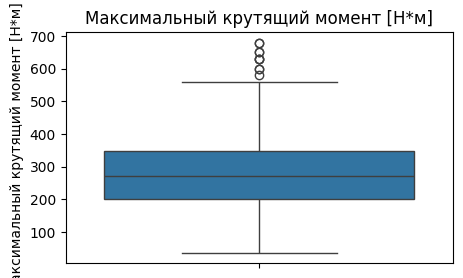

In [138]:
plot_boxplot(df, 'Максимальный крутящий момент [Н*м]')

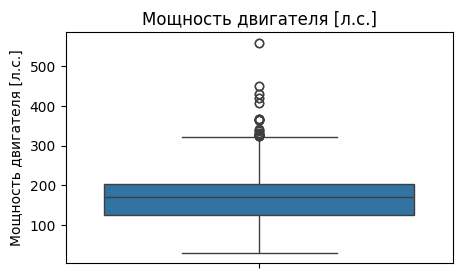

In [139]:
plot_boxplot(df, 'Мощность двигателя [л.с.]')

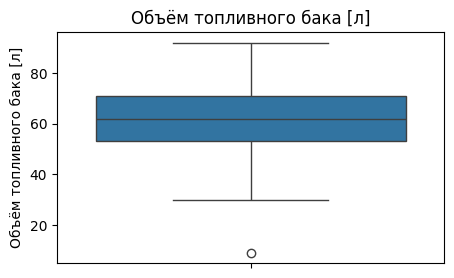

In [140]:
plot_boxplot(df, 'Объём топливного бака [л]')

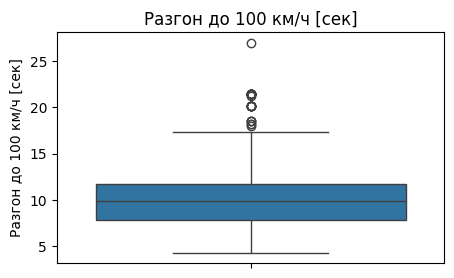

In [141]:
plot_boxplot(df, 'Разгон до 100 км/ч [сек]')

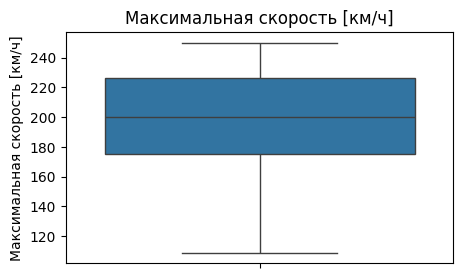

In [142]:
plot_boxplot(df, 'Максимальная скорость [км/ч]')

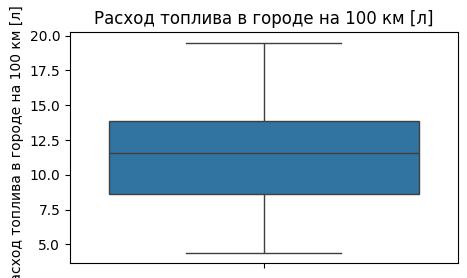

In [143]:
plot_boxplot(df, 'Расход топлива в городе на 100 км [л]')

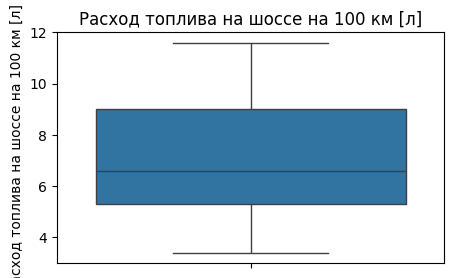

In [144]:
plot_boxplot(df, 'Расход топлива на шоссе на 100 км [л]')

In [145]:
df = replace_outliers_with_median(df, 'Полная масса [кг]')
df = replace_outliers_with_median(df, 'Максимальный крутящий момент [Н*м]')
df = replace_outliers_with_median(df, 'Мощность двигателя [л.с.]')
df = replace_outliers_with_median(df, 'Объём топливного бака [л]')
df = replace_outliers_with_median(df, 'Разгон до 100 км/ч [сек]')

## Поиск и обработка дубликатов.

In [146]:
df = remove_duplicates(df)

## Изучение баланса классов.

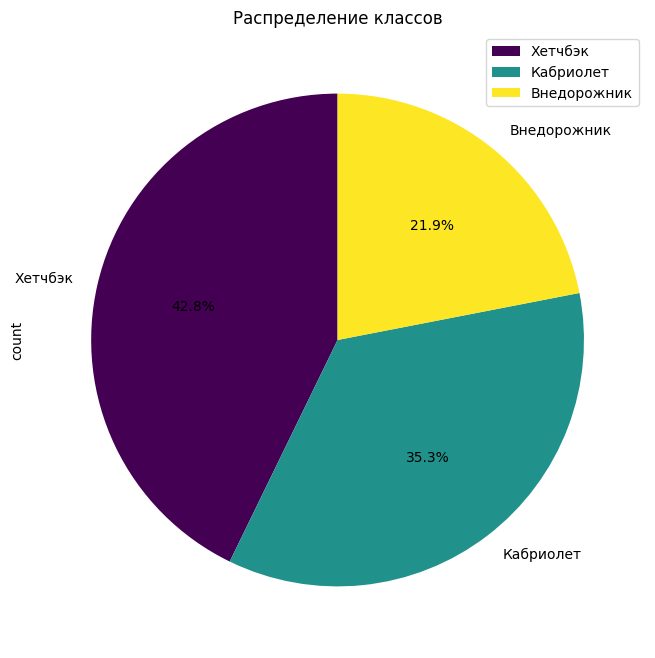

In [147]:
plot_pie_chart(df, 'Тип кузова')

## Изучение распределений.

Распределение данных не является нормальным (отвергаем нулевую гипотезу).


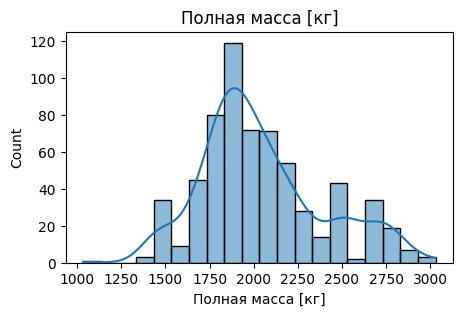

In [148]:
plot_distribution_and_check_normality(df, 'Полная масса [кг]')

Распределение данных не является нормальным (отвергаем нулевую гипотезу).


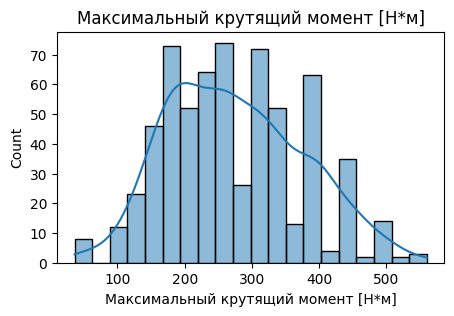

In [149]:
plot_distribution_and_check_normality(df, 'Максимальный крутящий момент [Н*м]')

Распределение данных не является нормальным (отвергаем нулевую гипотезу).


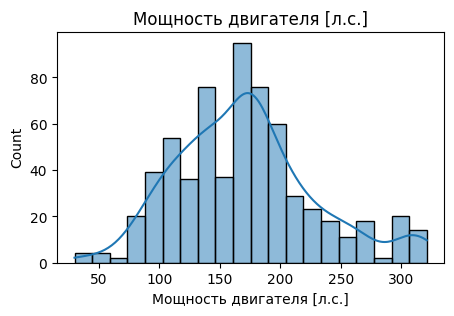

In [150]:
plot_distribution_and_check_normality(df, 'Мощность двигателя [л.с.]')

Распределение данных не является нормальным (отвергаем нулевую гипотезу).


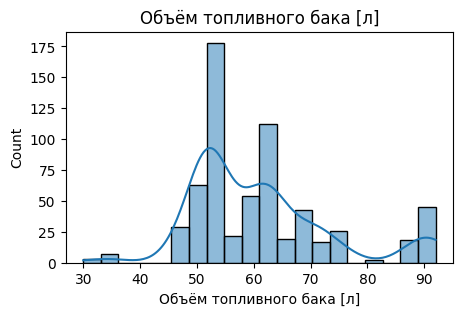

In [151]:
plot_distribution_and_check_normality(df, 'Объём топливного бака [л]')

Распределение данных не является нормальным (отвергаем нулевую гипотезу).


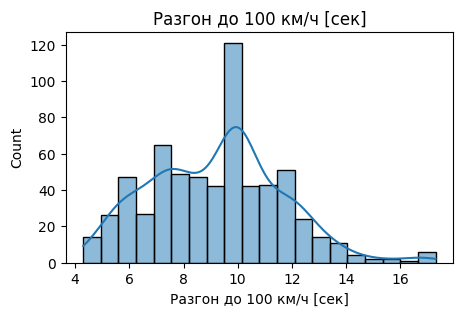

In [152]:
plot_distribution_and_check_normality(df, 'Разгон до 100 км/ч [сек]')

Распределение данных не является нормальным (отвергаем нулевую гипотезу).


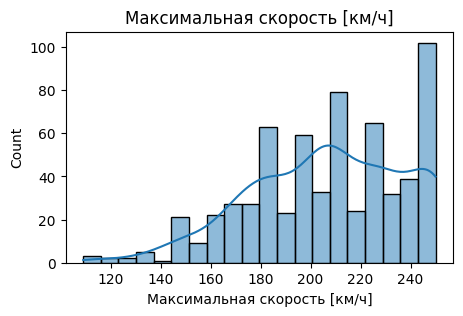

In [153]:
plot_distribution_and_check_normality(df, 'Максимальная скорость [км/ч]')

Распределение данных не является нормальным (отвергаем нулевую гипотезу).


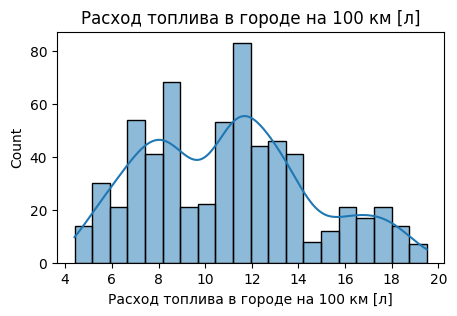

In [154]:
plot_distribution_and_check_normality(df, 'Расход топлива в городе на 100 км [л]')

Распределение данных не является нормальным (отвергаем нулевую гипотезу).


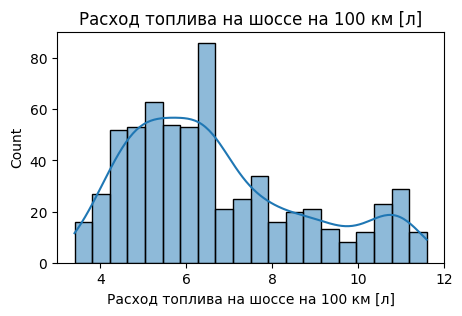

In [155]:
plot_distribution_and_check_normality(df, 'Расход топлива на шоссе на 100 км [л]')

## Изучение корреляционной зависимости признаков.

In [156]:
correlations_df = categorical_correlations(df, 'Тип кузова')
correlations_df

,Column,CramerV
0,Полная масса [кг],0.617648
1,Максимальный крутящий момент [Н*м],0.247450
2,Мощность двигателя [л.с.],0.300167
3,Объём топливного бака [л],0.662236
4,Разгон до 100 км/ч [сек],0.406800
5,Максимальная скорость [км/ч],0.527634
6,Расход топлива в городе на 100 км [л],0.450321
7,Расход топлива на шоссе на 100 км [л],0.579497


Признаки, которые оказывают заметное влияние на Тип кузова:
* полная масса (0.617648)
* объём топливного бака (0.662236)
* максимальная скорость (0.527634)
* расход топлива на шоссе на 100 км (0.579497)

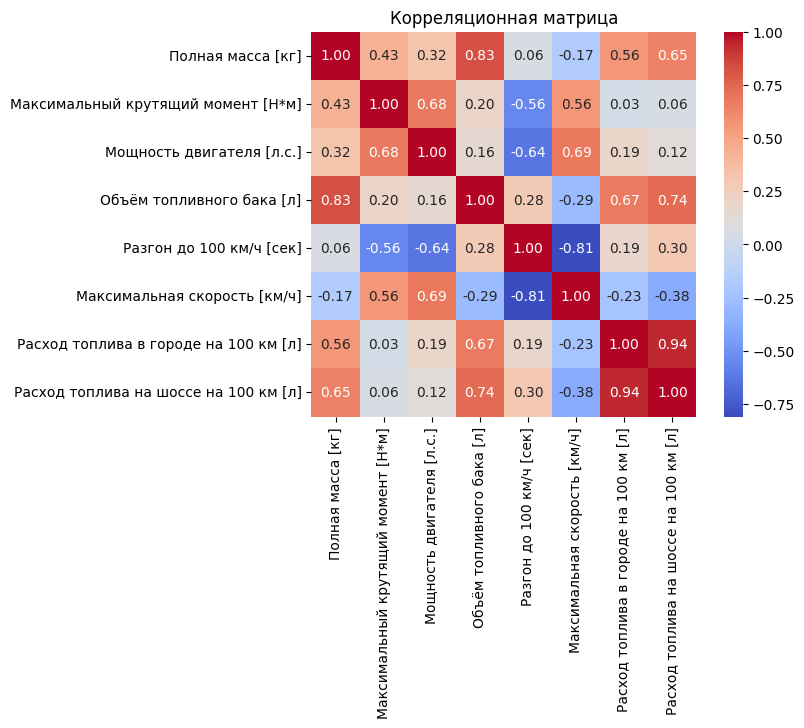

In [157]:
analyze_correlations(df)

Признаки, которые хуже всего коррелируют друг с другом:
* полная масса
* максимальная скорость

## Отбор признаков по дисперсии.

In [158]:
calculate_variances(df)

,0
Полная масса [кг],120703.825546
Максимальный крутящий момент [Н*м],10189.380727
Мощность двигателя [л.с.],3331.933052
Объём топливного бака [л],155.459073
Разгон до 100 км/ч [сек],5.899249
Максимальная скорость [км/ч],946.026840
Расход топлива в городе на 100 км [л],12.305726
Расход топлива на шоссе на 100 км [л],4.210036


Признаки, которые будут использоваться при обучении модели:
* полная масса
* максимальная скорость

In [159]:
columns_to_include = ['Тип кузова', 'Полная масса [кг]', 'Максимальная скорость [км/ч]']
df = df[columns_to_include]

## Масштабирование признаков.

In [160]:
df = scale_feature_with_robust_scaler(df, 'Полная масса [кг]')
df = scale_feature_with_robust_scaler(df, 'Максимальная скорость [км/ч]')

## Разделение выборки на обучающую и тестовую.

In [161]:
train_df, test_df = split_train_test(df, 0.15, 40)

# Обучение моделей.

## Обучение модели (baseline).

In [162]:
X_train = train_df.drop('Тип кузова', axis=1)
y_train = train_df['Тип кузова']
X_test = test_df.drop('Тип кузова', axis=1)
y_test = test_df['Тип кузова']

In [163]:
model = LogisticRegression(multi_class='ovr', solver='liblinear', random_state=40)
model.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', random_state=40, solver='liblinear')

In [164]:
y_pred = model.predict(X_test)

In [165]:
class_report = classification_report(y_test, y_pred)

In [166]:
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

 Внедорожник       0.83      0.91      0.87        11
   Кабриолет       0.63      0.67      0.65        39
     Хетчбэк       0.70      0.65      0.67        46

    accuracy                           0.69        96
   macro avg       0.72      0.74      0.73        96
weighted avg       0.69      0.69      0.69        96



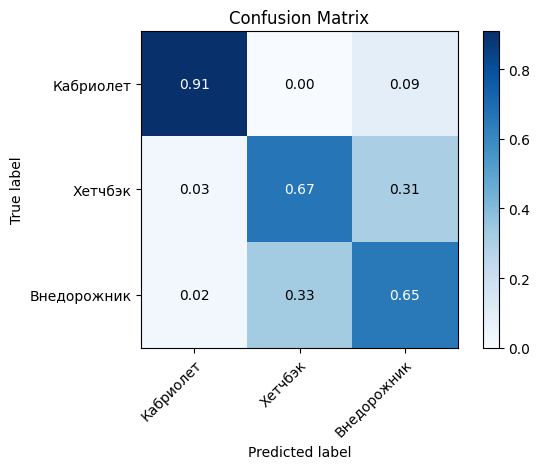

In [167]:
plot_confusion_matrix(y_test, y_pred, ['Кабриолет', 'Хетчбэк', 'Внедорожник'], normalize=True)

In [168]:
joblib.dump(model, 'Baseline.pkl')

['Baseline.pkl']

## Обучение модели (RandomForest).

In [169]:
rf = RandomForestClassifier(random_state=40)

In [170]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=40), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [171]:
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

In [172]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

 Внедорожник       0.91      0.91      0.91        11
   Кабриолет       0.81      0.74      0.77        39
     Хетчбэк       0.80      0.85      0.82        46

    accuracy                           0.81        96
   macro avg       0.84      0.83      0.83        96
weighted avg       0.81      0.81      0.81        96



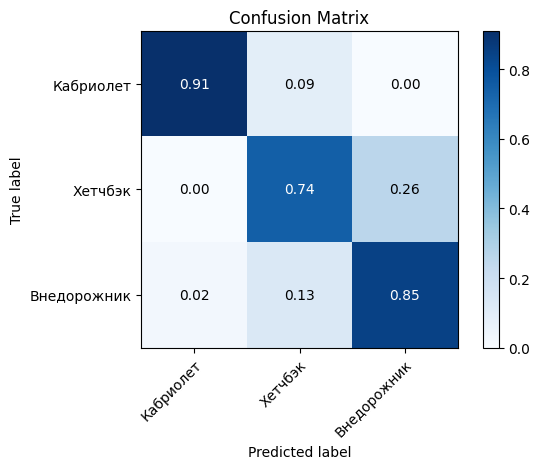

In [173]:
plot_confusion_matrix(y_test, y_pred, ['Кабриолет', 'Хетчбэк', 'Внедорожник'], normalize=True)

In [174]:
joblib.dump(best_rf, 'RandomForest.pkl')

['RandomForest.pkl']